In [1]:
# Copyright 2022 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# Serving Ranking Models With Merlin Systems

## Overview

NVIDIA Merlin is an open source framework that accelerates and scales end-to-end recommender system pipelines. The Merlin framework is broken up into several sub components, these include: Merlin-Core, Merlin-Models, NVTabular and Merlin-Systems. Merlin Systems will be the focus of this example.

The purpose of the Merlin Systems library is to make it easy for Merlin users to quickly deploy their recommender systems from development to [Triton Inference Server](https://github.com/triton-inference-server/server). We extended the same user-friendly API users are accustomed to in NVTabular and leveraged it to accommodate deploying your recommender system components to Triton. 

There are some things we need ensure before we continue with this Notebook. Please ensure you have a working workflow and model stored in an accessible location. As previously mentioned, Merlin Systems will take the data preprocessing workflow defined in NVTabular and load that into Triton as a model. Subsequently it will do the same for the trained model. Lets take a closer look in the rest of this notebook at how Merlin systems makes deploying to Triton simple and effortless.


**Be sure to check the other components of the Merlin framework, they can help you **

### Learning objectives

In this notebook, we learn how to deploy a NVTabular Workflow and a trained Tensorflow model from Merlin Models to Triton.
- Load NVTabular Workflow
- Load Pre-trained Merlin Models model
- Create Ensemble Graph
- Export Ensemble Graph
- Run Tritonserver
- Send Request to Tritonserver

### Dataset

In this notebook, we will be leveraging the [Alibaba dataset](https://tianchi.aliyun.com/dataset/dataDetail?dataId=408#1). It is important to note that the steps will take in this notebook are generalized and can be applied to any set of workflow and models. To see how the data is transformed please check the [NVTabular](https://github.com/NVIDIA-Merlin/NVTabular) example for the Alibaba dataset. And to see how an Alibaba dataset trained model is created check the [merlin-models](https://github.com/NVIDIA-Merlin/models)

### Tools

- NVTabular
- Merlin Models
- Merlin Systems
- Triton Inference Server

## Load an NVTabular Workflow

First, we load the `nvtabular.Workflow` that we created in with this [example](https://github.com/NVIDIA-Merlin/models/blob/main/examples/04-Exporting-ranking-models.ipynb). 

In [2]:
import os
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
from nvtabular.workflow import Workflow

input_path = os.environ.get("INPUT_FOLDER", "/workspace/data/")

workflow_stored_path = os.path.join(input_path, "workflow")

workflow = Workflow.load(workflow_stored_path)

/nvtabular/nvtabular/graph.py:23: FutureWarning: The `nvtabular.graph` module has moved to `merlin.dag`. Support for importing from `nvtabular.graph` is deprecated, and will be removed in a future version. Please update your imports to import from `merlin.dag`.
  warnings.warn(
/nvtabular/nvtabular/io.py:23: FutureWarning: The `nvtabular.io` module has moved to `merlin.io`. Support for importing from `nvtabular.io` is deprecated, and will be removed in a future version. Please update your imports to import from `merlin.io`.
  warnings.warn(
/nvtabular/nvtabular/utils.py:23: FutureWarning: The `nvtabular.utils` module has moved to `merlin.core.utils`. Support for importing from `nvtabular.utils` is deprecated, and will be removed in a future version. Please update your imports to import from `merlin.core.utils`.
  warnings.warn(
/nvtabular/nvtabular/dispatch.py:23: FutureWarning: The `nvtabular.dispatch` module has moved to `merlin.core.dispatch`. Support for importing from `nvtabular.d

After we load the workflow, we remove the label columns from it's inputs. This removes all columns with the `TARGET` tag from the workflow. We do this because we need to set the workflow to only  require the features needed to predict, not train, when creating an inference pipeline.

In [3]:
from merlin.schema.tags import Tags

label_columns = workflow.output_schema.select_by_tag(Tags.TARGET).column_names
workflow.remove_inputs(label_columns)

## Load a Tensorflow Model

After loading the workflow, we load the model. This model was trained with the output of the workflow from this [example](https://github.com/NVIDIA-Merlin/models/blob/main/examples/04-Exporting-ranking-models.ipynb).

In [4]:
import tensorflow as tf
tf_model_path = os.path.join(input_path, "dlrm")

model = tf.keras.models.load_model(tf_model_path)

2022-03-30 19:38:59.531435: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-30 19:39:01.547568: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:214] Using CUDA malloc Async allocator for GPU: 0
2022-03-30 19:39:01.547720: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 35814 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:15:00.0, compute capability: 7.5
2022-03-30 19:39:01.548314: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:214] Using CUDA malloc Async allocator for GPU: 1
2022-03-30 19:39:01.548374: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:

## Create the Ensemble Graph

Once we have both the model and the workflow loaded we can create the Ensemble Graph. This graph is created by the user, the goal is to illustrate the path of data through your full system. In this example we only serve a workflow with a model, but you can add other components that might be necessary to comply with business logic requirements.

For this example, because we have two components a model and a workflow we will require two operators. These operators, also known as Inference Operators, are meant to abstract away all the "hard parts" of loading a specific component (i.e. workflow or model) into tritonserver. 

In the following code block we will leverage two Inference operators, the TransformWorkflow operator and the PredictTensorflow operator. The TransformWorkflow operator ensures the workflow is correctly saved and packaged with the required config, so tritonserver will know how to load it. The PredictTensorflow operator will do something similar with the model, loaded before. 

Lets give it a try.

In [5]:
from merlin.systems.dag.ops.workflow import TransformWorkflow
from merlin.systems.dag.ops.tensorflow import PredictTensorflow

serving_operators = workflow.input_schema.column_names >> TransformWorkflow(workflow) >> PredictTensorflow(model)


## Export Graph as Ensemble

The last step is to create the ensemble artifacts that tritonserver can consume. To make these artifacts import the `Ensemble` class. It is responsible with interpreting the graph and exporting the correct files for tritonserver.

Below you will see that we create a ColumnSchema for the expected inputs to the workflow, which is a Schema. 

When you are creating an `Ensemble` object you supply the graph and a schema representing the starting input of the graph. the inputs to the ensemble graph are the inputs to the first operator of your graph. 

After you have created the `Ensemble` you export the graph, supplying an export path for the `Ensemble.export` function.

This returns an ensemble config which represents the entire inference pipeline and a list of node-specific configs.

Lets take a look below.

In [6]:
workflow.input_schema

[{'name': 'user_id', 'tags': set(), 'properties': {}, 'dtype': dtype('O'), 'is_list': False, 'is_ragged': False}, {'name': 'item_id', 'tags': set(), 'properties': {}, 'dtype': dtype('O'), 'is_list': False, 'is_ragged': False}, {'name': 'item_category', 'tags': set(), 'properties': {}, 'dtype': dtype('O'), 'is_list': False, 'is_ragged': False}, {'name': 'item_shop', 'tags': set(), 'properties': {}, 'dtype': dtype('O'), 'is_list': False, 'is_ragged': False}, {'name': 'item_brand', 'tags': set(), 'properties': {}, 'dtype': dtype('O'), 'is_list': False, 'is_ragged': False}, {'name': 'user_shops', 'tags': set(), 'properties': {}, 'dtype': dtype('O'), 'is_list': False, 'is_ragged': False}, {'name': 'user_profile', 'tags': set(), 'properties': {}, 'dtype': dtype('O'), 'is_list': False, 'is_ragged': False}, {'name': 'user_group', 'tags': set(), 'properties': {}, 'dtype': dtype('O'), 'is_list': False, 'is_ragged': False}, {'name': 'user_gender', 'tags': set(), 'properties': {}, 'dtype': dtype('

In [7]:
from merlin.systems.dag.ensemble import Ensemble
import numpy as np


ensemble = Ensemble(serving_operators, workflow.input_schema)

export_path = os.path.join(input_path, "ensemble")

ens_conf, node_confs = ensemble.export(export_path)

2022-03-30 19:39:05.797447: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-03-30 19:39:07.239921: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 788046592 exceeds 10% of free system memory.


INFO:tensorflow:Assets written to: /models/examples/processed/ensemble/1_predicttensorflow/1/model.savedmodel/assets


INFO:tensorflow:Assets written to: /models/examples/processed/ensemble/1_predicttensorflow/1/model.savedmodel/assets


## Verification of Ensemble Artifacts

Once the ensemble export has completed successfully, we can check the export path for the graph's artifacts. You should see a file structure that represents a ordering number followed by an operator identifier(i.e. `1_transformworkflow`, `2_predicttensorflow`). 

Inside each of those directories, the `export` method writes a `config.pbtxt` file and a directory with a number. The number indicates the version and begins at 1. The artifacts for each operator are found inside the version folder. These artifacts vary depending on the operator in question. 

Please see the snapshot below for verification.

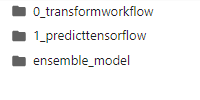

## Starting Triton Server

After we export the ensemble, we are ready to start the Triton Inference Server. First ensure it is installed in your environment otherwise find more install information here[link to triton build and install documentation]. Once installation is verified, you can start triton server by using the following command:

`tritonserver --model-repository=/ensemble_export_path/ --backend-config=tensorflow,version=2`

For the `--model-repository` argument, specify the same value as the `export_path` that you specified previously in the `ensemble.export` method.

## Retrieving Recommendations from Triton

Now that our tritonserver instance is running, we can send a request to it. This request is composed of values that correspond to the request schema created when exporting the ensemble graph.

In the code below we create a request to send to triton and send it. We will then analyze the response, to show the full experience.

First we need to ensure that we have a client connected to the tritonserver instance we launched previously. To do this we rely on the triton http client.

In [8]:
import tritonhttpclient

# create triton client
try:
    triton_client = tritonhttpclient.InferenceServerClient(url="localhost:8000", verbose=True)
    print("client created.")
except Exception as e:
    print("channel creation failed: " + str(e))

client created.


/usr/local/lib/python3.8/dist-packages/tritonhttpclient/__init__.py:31: DeprecationWarning: The package `tritonhttpclient` is deprecated and will be removed in a future version. Please use instead `tritonclient.http`
  warnings.warn(


Once we have created the client and verified it is connected to the tritonserver instance, we can communicate with the server and ensure all the models have been loaded correctly.

In [9]:
# ensure triton is in a good state
triton_client.is_server_live()
triton_client.get_model_repository_index()

GET /v2/health/live, headers None
<HTTPSocketPoolResponse status=200 headers={'content-length': '0', 'content-type': 'text/plain'}>
POST /v2/repository/index, headers None

<HTTPSocketPoolResponse status=200 headers={'content-type': 'application/json', 'content-length': '179'}>
bytearray(b'[{"name":"0_transformworkflow","version":"1","state":"READY"},{"name":"1_predicttensorflow","version":"1","state":"READY"},{"name":"ensemble_model","version":"1","state":"READY"}]')


[{'name': '0_transformworkflow', 'version': '1', 'state': 'READY'},
 {'name': '1_predicttensorflow', 'version': '1', 'state': 'READY'},
 {'name': 'ensemble_model', 'version': '1', 'state': 'READY'}]

After verifying the models are correctly loaded by triton we grab some original test data and send it as an inference request to triton. Note: `df_lib` is cudf if a GPU is available and pandas otherwise.

In [10]:
from merlin.core.dispatch import get_lib

df_lib = get_lib()
original_data_path = os.environ.get("DATA_FOLDER", "/workspace/data/")

# read in data for request
batch = df_lib.read_parquet(
    os.path.join(original_data_path,"test", "test_0.parquet"), num_rows=3, columns=workflow.input_schema.column_names
)
batch

,user_id,item_id,item_category,item_shop,item_brand,user_shops,user_profile,user_group,user_gender,user_age,user_consumption_2,user_is_occupied,user_geography,user_intentions,user_brands,user_categories
0,31390,5587143,8315277,8801026,9181078,568260,3438658,3438762,3438769,3438774,3438782,3864885,3864887,3912301,3812616,449068
1,31390,5662732,8316893,8987328,9206290,568260,3438658,3438762,3438769,3438774,3438782,3864885,3864887,3912301,3812616,449068
2,31390,6539512,8315405,8546676,9273427,568260,3438658,3438762,3438769,3438774,3438782,3864885,3864887,3912301,3812616,449068


Once we isolate our `batch`, we convert the dataframe representation into triton inputs. We also declare the outputs we expect to receive from the model.

In [11]:
from merlin.systems.triton import convert_df_to_triton_input
import tritonclient.grpc as grpcclient
# create inputs and outputs

inputs = convert_df_to_triton_input(workflow.input_schema.column_names, batch, grpcclient.InferInput)


outputs = [
    grpcclient.InferRequestedOutput(col)
    for col in ensemble.graph.output_schema.column_names
]

Once our `inputs` and `outputs` are created, we can use the `triton_client` created earlier to send the inference request.

In [12]:
# send request to tritonserver
with grpcclient.InferenceServerClient("localhost:8001") as client:
    response = client.infer("ensemble_model", inputs, request_id="1", outputs=outputs)

When Triton completes the inference request, it returns a Triton inference response. This response is parsed to get the desired predictions.

In [13]:
# access individual response columns to get values back.
for col in ensemble.graph.output_schema.column_names:
    print(col, response.as_numpy(col), response.as_numpy(col).shape)

output_1 [[0.05209467]
 [0.05619942]
 [0.01078821]] (3, 1)
